# Population rate model of generalized integrate-and-fire neurons

This script simulates a finite network of generalized integrate-and-fire (GIF) neurons directly on the *mesoscopic* population level using the effective stochastic population rate dynamics derived in the paper [*Schwalger et al. PLoS Comput Biol. 2017*]. The stochastic population dynamics is implemented in the NEST model **`gif_pop_psc_exp`**. We demonstrate this model using the example of a Brunel network of two coupled populations, one exhitory and one inhibitory population. 

Note that the population model represents the mesoscopic level description of the corresponding microscopic network based on the NEST model **`gif_psc_exp`**.

At first, we load the necessary modules:

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import nest

Next, we set the parameters of the microscopic model

In [2]:
#all times given in milliseconds

dt=0.5
dt_rec=1.

#Simulation time
t_end=2000.

#Parameters
size = 200
N = np.array([ 4, 1 ]) * size
M = len(N)                #number of populations

#neuronal parameters
t_ref = 4. * np.ones(M)     #absolute refractory period
tau_m = 20 * np.ones(M)     #membrane time constant
mu = 24. * np.ones(M)       #constant base current mu=R*(I0+Vrest)
c = 10. * np.ones(M)        #base rate of exponential link function
Delta_u = 2.5 * np.ones(M)  #softness of exponential link function
V_reset = 0. * np.ones(M)   #Reset potential
V_th =    15. * np.ones(M)  #baseline threshold (non-accumulating part)
tau_sfa_exc = [100., 1000.] #adaptation time constants of excitatory neurons
tau_sfa_inh = [100., 1000.] #adaptation time constants of inhibitory neurons
J_sfa_exc = [1000.,1000.]   #size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [1000.,1000.]   #in mV*ms
tau_theta = np.array([tau_sfa_exc, tau_sfa_inh])
J_theta =   np.array([J_sfa_exc,   J_sfa_inh  ])

#connectivity
J = 0.3  #excitatory synaptic weight in mV if number of input connections is C0 (see below)
g = 5.   #inhibition-to-excitation ratio
pconn = 0.2 * np.ones((M, M))
delay = 1. * np.ones((M, M))

C0 = np.array([[ 800, 200 ], [800, 200]]) * 0.2 #constant reference matrix
C = np.vstack((N,N)) * pconn                    #numbers of input connections

J_syn = np.array([[ J, -g * J], [J, -g * J]]) * C0 / C #final synaptic weights scaling as 1/C

taus1_ = [3., 6.]  #time constants of exc. and inh. post-synaptic currents (PSC's)
taus1 =  np.array([taus1_ for k in range(M)])


#step current input
step=[[20.],[20.]]   #jump size of mu in mV
tstep=np.array([[1500.],[1500.]]) #times of jumps

#synaptic time constants of excitatory and inhibitory connections
tau_ex = 3.  # in ms
tau_in = 6.  # in ms

### Simulation on the mesoscopic level

To directly simulate the mesoscopic population activities (i.e. generating the activity of a finite-size population without simulating single neurons), we can build the populations using the NEST model **`gif_pop_psc_exp`**:

In [3]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()
nest.SetKernelStatus({'resolution': dt, 'print_time': True, 'local_num_threads': 1})
t0=nest.GetKernelStatus('time')

nest_pops = nest.Create('gif_pop_psc_exp', M)

C_m = 250. # irrelavant value for membrane capacity, cancels out in simulation
g_L = C_m / tau_m
for i, nest_i in enumerate( nest_pops ):
    nest.SetStatus([nest_i], {
        'C_m': C_m,  
        'I_e': mu[i] * g_L[i],
        'lambda_0': c[i],  # in Hz!
        'Delta_V': Delta_u[i],
        'tau_m': tau_m[i],
        'tau_sfa': tau_theta[i],
        'q_sfa': J_theta[i] / tau_theta[i], # [J_theta]= mV*ms -> [q_sfa]=mV
        'V_T_star': V_th[i],
        'V_reset': V_reset[i],
        'len_kernel': -1,             # -1 triggers automatic history size
        'N': N[i],
        't_ref': t_ref[i],
        'tau_syn_ex': max([tau_ex, dt]),
        'tau_syn_in': max([tau_in, dt]),
        'E_L': 0.
    })


# connect the populations
g_syn = np.ones_like(J_syn)  #synaptic conductance
g_syn[:,0] = C_m / tau_ex 
g_syn[:,1] = C_m / tau_in
for i, nest_i in enumerate( nest_pops ):
    for j, nest_j in enumerate( nest_pops ):
        nest.SetDefaults('static_synapse', {
            'weight': J_syn[i,j] * g_syn[i,j] * pconn[i,j],
            'delay': delay[i,j]} )
        nest.Connect( [nest_j], [nest_i], 'all_to_all')      


To record the instantaneous population rate $\bar A(t)$ we use a multimeter, and to get the population activity $A_N(t)$ we use spike detector: 

In [4]:
# monitor the output using a multimeter, this only records with dt_rec!
nest_mm = nest.Create('multimeter')
nest.SetStatus( nest_mm, {'record_from':['n_events', 'mean'],
                          'withgid': True,
                          'withtime': False,
                          'interval': dt_rec})
nest.Connect(nest_mm, nest_pops, 'all_to_all')
        
# monitor the output using a spike detector
nest_sd = []
for i, nest_i in enumerate( nest_pops ):
    nest_sd.append( nest.Create('spike_detector') )
    nest.SetStatus( nest_sd[i], {'withgid': False, 
                                 'withtime': True,
                                 'time_in_steps': True})
    nest.SetDefaults('static_synapse', {'weight': 1.,
                                        'delay': dt} )
    nest.Connect( [nest_pops[i]], nest_sd[i], 'all_to_all')    


All neurons in a given population will be stimulated with a step input current:

In [5]:
#set initial value (at t0+dt) of step current generator to zero

tstep = np.hstack((dt * np.ones((M,1)), tstep))
step =  np.hstack((np.zeros((M,1)), step))
    
# create the step current devices
nest_stepcurrent = nest.Create('step_current_generator', M )
# set the parameters for the step currents
for i in range(M):
    nest.SetStatus( [nest_stepcurrent[i]], {
        'amplitude_times': tstep[i] + t0,
        'amplitude_values': step[i] *g_L[i], 'origin': t0, 'stop': t_end})
    pop_ = nest_pops[i]
    if type(nest_pops[i])==int:
        pop_ = [pop_]
    nest.Connect( [nest_stepcurrent[i]], pop_, syn_spec={'weight':1.} )


We can now start the simulation:

In [6]:
local_num_threads = 1
seed=1
msd =local_num_threads * seed + 1 #master seed
nest.SetKernelStatus({'rng_seeds': range(msd, msd + local_num_threads)})
    
t = np.arange(0., t_end, dt_rec)
A_N = np.ones( (t.size, M) ) * np.nan
Abar = np.ones_like( A_N ) * np.nan
    
#simulate 1 step longer to make sure all t are simulated
nest.Simulate(t_end + dt)
data_mm = nest.GetStatus( nest_mm )[0]['events']
for i, nest_i in enumerate( nest_pops ):
    a_i  = data_mm['mean'][ data_mm['senders']==nest_i ]
    a = a_i / N[i] / dt
    min_len = np.min([len(a), len(Abar)])
    Abar[:min_len,i] = a[:min_len]

    data_sd = nest.GetStatus(nest_sd[i], keys=['events'])[0][0]['times'] * dt - t0
    bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
    A = np.histogram(data_sd, bins=bins)[0] / float(N[i]) / dt_rec
    A_N[:,i]=A

and plot the activity:

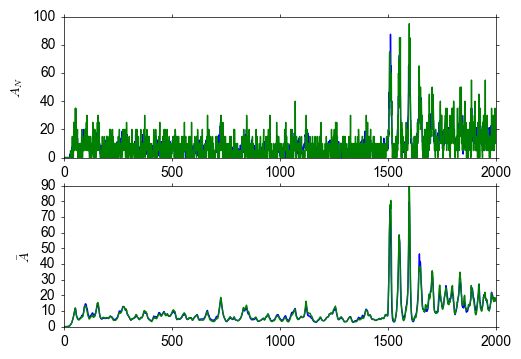

In [7]:
plt.clf()
plt.subplot(2,1,1)
plt.plot(t,A_N*1000) #plot population activities (in Hz)
plt.ylabel(r'$A_N$')
plt.subplot(2,1,2)
plt.plot(t,Abar*1000) #plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$')

### Microscopic ("direct") simulation

As mentioned above, the population model **`gif_pop_psc_exp`** directly simulates the mesoscopic population activities, i.e. without the need to simulate single neurons. On the other hand, if we want to know single neuron activities, we must simulate on the microscopic level. This is possible by building a corresponding network of **`gif_psc_exp`** neuron models: 

In [8]:
nest.ResetKernel()
nest.SetKernelStatus({'resolution': dt, 'print_time': True, 'local_num_threads': 1})
t0=nest.GetKernelStatus('time')

nest_pops = nest.Create('gif_pop_psc_exp', M)

nest_pops = []
for k in range(M):
    nest_pops.append( nest.Create('gif_psc_exp', N[k]) )

# set single neuron properties
for i, nest_i in enumerate( nest_pops ):
    nest.SetStatus(nest_i, {
        'C_m': C_m,  
        'I_e': mu[i] * g_L[i],
        'lambda_0': c[i],  # in Hz!
        'Delta_V': Delta_u[i],
        'g_L': g_L[i],
        'tau_sfa': tau_theta[i],
        'q_sfa': J_theta[i] / tau_theta[i], # [J_theta]= mV*ms -> [q_sfa]=mV
        'V_T_star': V_th[i],
        'V_reset': V_reset[i],
        't_ref': t_ref[i],
        'tau_syn_ex': max([tau_ex, dt]),
        'tau_syn_in': max([tau_in, dt]),
        'E_L': 0.,
        'V_m': 0.
    })        
           

# connect the populations
for i, nest_i in enumerate( nest_pops ):
    for j, nest_j in enumerate( nest_pops ):
        nest.SetDefaults('static_synapse', {
            'weight': J_syn[i,j] * g_syn[i,j],
            'delay': delay[i,j]} )
        
        if np.allclose( pconn[i,j], 1. ):
            conn_spec = {'rule': 'all_to_all'}
        else:
            conn_spec = {'rule': 'fixed_indegree', 'indegree': int(pconn[i,j] * N[j])}

        nest.Connect( nest_j, nest_i, conn_spec )
             
             

We want to record all spikes of each population in order to compute the mesoscopic population activities $A_N(t)$ from the microscopic simulation. We also record the membrane potentials of five example neurons: 

In [9]:
# monitor the output using a multimeter and a spike detector
nest_sd = []
for i, nest_i in enumerate(nest_pops ):
    nest_sd.append( nest.Create('spike_detector') )
    nest.SetStatus(nest_sd[i], {'withgid': False, 
                                 'withtime': True, 'time_in_steps': True})
    nest.SetDefaults('static_synapse', {'weight': 1., 'delay': dt} )
    
    #record all spikes from population to compute population activity
    nest.Connect(nest_pops[i], nest_sd[i], 'all_to_all') 

Nrecord=[5,0] #for each population i the first Nrecord[i] neurons are recorded    
nest_mm_Vm = []
for i, nest_i in enumerate( nest_pops ):
    nest_mm_Vm.append( nest.Create('multimeter') )
    nest.SetStatus(nest_mm_Vm[i], {'record_from':['V_m'], \
                                   'withgid': True, 'withtime': True, \
                                   'interval': dt_rec})
    nest.Connect(nest_mm_Vm[i], list( np.array(nest_pops[i])[:Nrecord[i]]), 'all_to_all')

As before, all neurons in a given population will be stimulated with a step input current. The following code block is identical to the one for the mesoscopic simulation above:

In [10]:
# create the step current devices if they do not exist already
nest_stepcurrent = nest.Create('step_current_generator', M )
# set the parameters for the step currents
for i in range(M):
    nest.SetStatus( [nest_stepcurrent[i]], {
        'amplitude_times': tstep[i] + t0,
        'amplitude_values': step[i] *g_L[i], 'origin': t0, 'stop': t_end #, 'stop': sim_T + t0
    })
    pop_ = nest_pops[i]
    if type(nest_pops[i])==int:
        pop_ = [pop_]
    nest.Connect( [nest_stepcurrent[i]], pop_, syn_spec={'weight':1.} )


We can now start the microscopic simulation:

In [11]:
local_num_threads = 1
seed=1
msd =local_num_threads * seed + 1 #master seed
nest.SetKernelStatus({'rng_seeds': range(msd, msd + local_num_threads)})
    
t = np.arange(0., t_end, dt_rec)
A_N = np.ones( (t.size, M) ) * np.nan
    
#simulate 1 step longer to make sure all t are simulated
nest.Simulate(t_end + dt)


Let's retrieve the data of the spike detector and plot the activity of the excitatory population (in Hz):

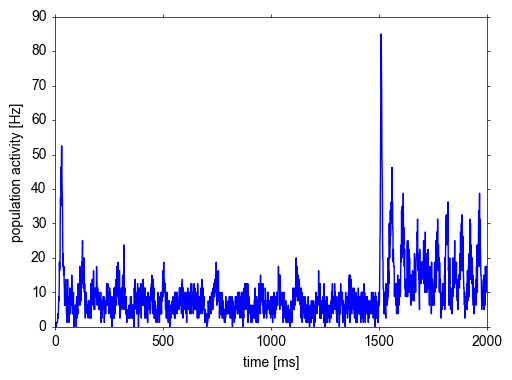

In [12]:
for i, nest_i in enumerate( nest_pops ):
    data_sd = nest.GetStatus(nest_sd[i], keys=['events'])[0][0]['times'] * dt - t0
    bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
    A = np.histogram(data_sd, bins=bins)[0] / float(N[i]) / dt_rec
    A_N[:,i]=A * 1000 #in Hz

t = np.arange(dt,t_end+dt,dt_rec)
plt.plot(t, A_N[:,0])
plt.xlabel('time [ms]')
plt.ylabel('population activity [Hz]')
        

This looks similar to the population activity obtained from the mesoscopic simulation based on the NEST model **`gif_pop_psc_exp`** (cf. previous figure). Now we retrieve the data of the multimeter, which allows us to look at the membrane potentials of single neurons. Here we plot the voltage traces (in mV) of five example neurons:

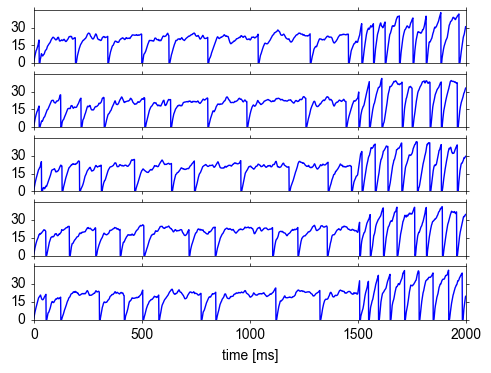

In [13]:
voltage=[]
for i in range(M):
    if Nrecord[i]>0:
        senders = nest.GetStatus(nest_mm_Vm[i])[0]['events']['senders']
        v = nest.GetStatus(nest_mm_Vm[i])[0]['events']['V_m']
        voltage.append( np.array([v[np.where(senders==j)] for j in set(senders)]) )
    else:
        voltage.append(np.array([]))

f, axarr = plt.subplots(Nrecord[0], sharex=True)
for i in range(Nrecord[0]):
    axarr[i].plot(voltage[0][i])
    axarr[i].set_yticks((0,15,30))
axarr[i].set_xlabel('time [ms]')

Note that this plot only shows the subthreshold membrane potentials but not the spikes (as with every leaky integrate-and-fire model). 